# Flat file generation

### choosing the relevant  data from the data base
In this notebook we are going to take a first glance of the data and choosing the rellavant parameters and loans to answer our quotation.

![title](ERData.jpg)

In [1]:
##Importing required packages 
if(!require(DBI)){install.packages("DBI"); require(DBI)}
if(!require(RSQLite)){install.packages("RSQLite"); require(RSQLite)}
if(!require(dplyr)){install.packages("dplyr"); require(dplyr)}
if(!require(readxl)){install.packages("readxl"); require(readxl)}
if(!require(tableone)){install.packages("tableone"); require(tableone)}
if(!require(funModeling)){install.packages("funModeling"); require(funModeling)}
if(!require(openintro)){install.packages("openintro"); require(openintro)}

Loading required package: DBI
Loading required package: RSQLite
Loading required package: dplyr

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: readxl
Loading required package: tableone
Warning message:
"package 'tableone' was built under R version 3.5.2"Loading required package: funModeling
Warning message:
"package 'funModeling' was built under R version 3.5.2"Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: 'Hmisc'

The following objects are masked from 'package:dplyr':

    src, summarize

The following objects are masked from 'package:base':

    format.pval, units

funModeling v.1.6.8 :)
Examples and tutorials at livebook.datascienceheroes.com

Loading required package:

In [2]:
##############################################################################
##########                DATABASE FUNCTIONS                     #############
##############################################################################
            

#### Read function to import data from the SQL to a pandas dataframe.
readSQL <- function(query, db=DB_FILE) {
    require(DBI)
    require(RSQLite)
    con <- dbConnect(SQLite(), DB_FILE)
    df <- dbGetQuery(con, query)
    return(df)
}

#### Write a pandas dataframe into an SQL table. Use overwrite=True if you want to delete 
#### first a pre-existent table with the same name. Use append=True if you want to append
#### the data in the dataframe to a pre-existent table.
writeSQL <- function(df,tablename,overwrite=FALSE, append=FALSE,db=DB_FILE) {
    require(DBI)
    require(RSQLite)
    con <- dbConnect(SQLite(), DB_FILE)
    dbWriteTable(con,tablename,df,overwrite,append)
}
####

In [3]:
DB_FILE = paste0(getwd(),"/Data/loans.db") 

In [4]:
loans = readSQL("SELECT * FROM v_loans")

In [5]:
#make a copy - for restore if necessary 
loansdata <- loans

In [6]:
dim(loans)

[1] 887382     74

We can see that we have 887382 loans and 74 features.

#### Data description
    Data Features description by Lending Club

In [7]:
# Load the Excel workbook
path <- getwd()
excel_file <- paste0("/lcdatadictionary.xlsx")
# see available tabs
excel_sheets(paste0(path, excel_file))
meta_loan_stats <- read_excel(paste0(path, excel_file), sheet = "LoanStats")

[1] "LoanStats"   "browseNotes" "RejectStats" "ניתוח שלי"

In [8]:
meta_loan_stats[,1:2]

LoanStatNew,Description
acc_now_delinq,The number of accounts on which the borrower is now delinquent.
addr_state,The state provided by the borrower in the loan application
all_util,Balance to credit limit on all trades
annual_inc,The self-reported annual income provided by the borrower during registration.
annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
collection_recovery_fee,post charge off collection fee
collections_12_mths_ex_med,Number of collections in 12 months excluding medical collections
delinq_2yrs,The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
desc,Loan description provided by the borrower


Sorting the parameters by their type

In [9]:
split(names(loans),sapply(loans, function(x) paste(class(x), collapse=" ")))

$character
 [1] "verification_status"       "issue_d"                  
 [3] "loan_status"               "url"                      
 [5] "loanDesc"                  "purpose"                  
 [7] "title"                     "verification_status_joint"
 [9] "grade"                     "sub_grade"                
[11] "emp_title"                 "emp_length"               
[13] "zip_code"                  "addr_state"               
[15] "last_pymnt_d"              "next_pymnt_d"             
[17] "last_credit_pull_d"        "home_ownership"           
[19] "earliest_cr_line"         

$integer
 [1] "loan_id"                     "member_id"                  
 [3] "pymnt_plan"                  "policy_code"                
 [5] "application_type"            "initial_list_status"        
 [7] "loan_amnt"                   "funded_amnt"                
 [9] "term"                        "collections_12_mths_ex_med" 
[11] "mths_since_last_major_derog" "delinq_2yrs"                
[13] "acc_now_delinq"              "inq_last_6mths"             
[15] "mths_since_last_delinq"      "mths_since_last_record"     
[17] "open_acc"                    "pub_rec"                    
[19] "total_acc"                   "tot_coll_amt"               
[21] "open_acc_6m"                 "open_il_6m"                 
[23] "open_il_12m"                 "open_il_24m"                
[25] "mths_since_rcnt_il"          "total_bal_il"               
[27] "open_rv_12m"                 "open_rv_24m"                
[29] "max_bal_bc"                  "inq_fi"                     
[31] "total_cu_tl"                 "inq_last_12m"               

$numeric
 [1] "funded_amnt_inv"         "int_rate"               
 [3] "installment"             "out_prncp"              
 [5] "out_prncp_inv"           "total_pymnt"            
 [7] "total_pymnt_inv"         "total_rec_prncp"        
 [9] "total_rec_int"           "total_rec_late_fee"     
[11] "recoveries"              "collection_recovery_fee"
[13] "last_pymnt_amnt"         "annual_inc"             
[15] "dti"                     "annual_inc_joint"       
[17] "dti_joint"               "revol_bal"              
[19] "revol_util"              "tot_cur_bal"            
[21] "il_util"                 "all_util"               
[23] "total_rev_hi_lim"

In [10]:
## numeric variables
num_vars <- 
  loans %>% 
  sapply(is.numeric) %>% 
  which() %>% 
  names()
num_vars
length(num_vars)

[1] "loan_id"                     "member_id"                  
 [3] "pymnt_plan"                  "policy_code"                
 [5] "application_type"            "initial_list_status"        
 [7] "loan_amnt"                   "funded_amnt"                
 [9] "funded_amnt_inv"             "term"                       
[11] "int_rate"                    "installment"                
[13] "out_prncp"                   "out_prncp_inv"              
[15] "total_pymnt"                 "total_pymnt_inv"            
[17] "total_rec_prncp"             "total_rec_int"              
[19] "total_rec_late_fee"          "recoveries"                 
[21] "collection_recovery_fee"     "last_pymnt_amnt"            
[23] "collections_12_mths_ex_med"  "mths_since_last_major_derog"
[25] "annual_inc"                  "dti"                        
[27] "delinq_2yrs"                 "annual_inc_joint"           
[29] "dti_joint"                   "acc_now_delinq"             
[31] "inq_last_6mths"              "mths_since_last_delinq"     
[33] "mths_since_last_record"      "open_acc"                   
[35] "pub_rec"                     "revol_bal"                  
[37] "revol_util"                  "total_acc"                  
[39] "tot_coll_amt"                "tot_cur_bal"                
[41] "open_acc_6m"                 "open_il_6m"                 
[43] "open_il_12m"                 "open_il_24m"                
[45] "mths_since_rcnt_il"          "total_bal_il"               
[47] "il_util"                     "open_rv_12m"                
[49] "open_rv_24m"                 "max_bal_bc"                 
[51] "all_util"                    "total_rev_hi_lim"           
[53] "inq_fi"                      "total_cu_tl"                
[55] "inq_last_12m"

[1] 55

#### Fixing Dates Columns

In [11]:
chr_to_date_vars <- 
  c("issue_d", "last_pymnt_d", "last_credit_pull_d",
    "next_pymnt_d", "earliest_cr_line")

loans %>%
  select_(.dots = chr_to_date_vars) %>%
  str()

'data.frame':	887382 obs. of  5 variables:
 $ issue_d           : chr  "Dec-2011" "Dec-2011" "Dec-2011" "Dec-2011" ...
 $ last_pymnt_d      : chr  "Jan-2015" "Apr-2013" "Jun-2014" "Jan-2015" ...
 $ last_credit_pull_d: chr  "Jan-2016" "Sep-2013" "Jan-2016" "Jan-2015" ...
 $ next_pymnt_d      : chr  NA NA NA NA ...
 $ earliest_cr_line  : chr  "Jan-1985" "Apr-1999" "Nov-2001" "Feb-1996" ...


<p>We can see that all the dates are in format of <strong>"abbreviated month"-"year"</strong></p>
<p style="padding-left: 30px;">We will add "01-" to the string value to complete the date in a format off "%d-%b-%Y"<br />and then convert it to date type with the as.Date function</p>

In [12]:
##convert-date as string to Date Variable
convert_date <- function(x){
  as.Date(paste0("01-", x), format = "%d-%b-%Y")
  } 
lct <- Sys.getlocale("LC_TIME"); Sys.setlocale("LC_TIME", "C")
loans <-
  loans %>%
  mutate_at(.funs = funs(convert_date), .vars = chr_to_date_vars)
Sys.setlocale("LC_TIME", lct)

[1] "C"

[1] "Hebrew_Israel.1255"

In [13]:
##check if the conversion was successfuly done
loans %>%
  select_(.dots = chr_to_date_vars) %>%
  str()

'data.frame':	887382 obs. of  5 variables:
 $ issue_d           : Date, format: "2011-12-01" "2011-12-01" ...
 $ last_pymnt_d      : Date, format: "2015-01-01" "2013-04-01" ...
 $ last_credit_pull_d: Date, format: "2016-01-01" "2013-09-01" ...
 $ next_pymnt_d      : Date, format: NA NA ...
 $ earliest_cr_line  : Date, format: "1985-01-01" "1999-04-01" ...


In [14]:
## categorical variables
cv <- setdiff(names(loans),c(chr_to_date_vars,num_vars))
cv

[1] "verification_status"       "loan_status"              
 [3] "url"                       "loanDesc"                 
 [5] "purpose"                   "title"                    
 [7] "verification_status_joint" "grade"                    
 [9] "sub_grade"                 "emp_title"                
[11] "emp_length"                "zip_code"                 
[13] "addr_state"                "home_ownership"

In [15]:
loans %>%
  select_(.dots = cv) %>%
  str()

'data.frame':	887382 obs. of  14 variables:
 $ verification_status      : chr  "Verified" "Source Verified" "Not Verified" "Source Verified" ...
 $ loan_status              : chr  "Fully Paid" "Charged Off" "Fully Paid" "Fully Paid" ...
 $ url                      : chr  "https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501" "https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430" "https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175" "https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863" ...
 $ loanDesc                 : chr  "  Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>" "  Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to ha"| __truncated__ NA "  Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C nee"| __truncated__ ...
 $ purpose                  : chr  "credit_card" "car" "sma

In [16]:
meta_loans <- funModeling::df_status(loans, print_results = FALSE)

In [17]:
meta_loans%>%
  knitr::kable()



|variable                    | q_zeros| p_zeros|   q_na|  p_na| q_inf| p_inf|type      | unique|
|:---------------------------|-------:|-------:|------:|-----:|-----:|-----:|:---------|------:|
|loan_id                     |       0|    0.00|      0|  0.00|     0|     0|integer   | 887382|
|member_id                   |       0|    0.00|      0|  0.00|     0|     0|integer   | 887382|
|verification_status         |       0|    0.00|      0|  0.00|     0|     0|character |      3|
|issue_d                     |       0|    0.00|      0|  0.00|     0|     0|Date      |    103|
|loan_status                 |       0|    0.00|      0|  0.00|     0|     0|character |     10|
|pymnt_plan                  |  887372|  100.00|      0|  0.00|     0|     0|integer   |      2|
|url                         |       0|    0.00|      0|  0.00|     0|     0|character | 887382|
|loanDesc                    |       0|    0.00| 761353| 85.80|     0|     0|character | 124470|
|purpose                    

In [19]:
meta_loans <-
  meta_loans %>%
  mutate(uniq_rat = unique / nrow(loans))

meta_loans %>%
  select(variable, unique, uniq_rat) %>%
  mutate(unique = unique, uniq_rat = scales::percent(uniq_rat))

variable,unique,uniq_rat
loan_id,887382,100.0%
member_id,887382,100.0%
verification_status,3,0.0%
issue_d,103,0.0%
loan_status,10,0.0%
pymnt_plan,2,0.0%
url,887382,100.0%
loanDesc,124470,14.0%
purpose,14,0.0%
title,63145,7.1%


In [20]:
meta_loans %>%
  select(variable, p_zeros, p_na, unique, uniq_rat) %>%
  mutate(unique = unique, uniq_rat = scales::percent(uniq_rat))%>% filter_(~ variable %in% num_vars)%>% arrange(desc(unique))

variable,p_zeros,p_na,unique,uniq_rat
loan_id,0.00,0.00,887382,100.0%
member_id,0.00,0.00,887382,100.0%
total_pymnt,2.00,0.00,509124,57.4%
total_pymnt_inv,2.03,0.00,506619,57.1%
tot_cur_bal,0.01,7.92,327342,36.9%
total_rec_int,2.05,0.00,324636,36.6%
out_prncp_inv,28.83,0.00,266245,30.0%
total_rec_prncp,2.04,0.00,260228,29.3%
out_prncp,28.83,0.00,248333,28.0%
last_pymnt_amnt,1.99,0.00,232452,26.2%


<h3>Excluding Columns (1)</h3>
<ol>
<li>It seems the data has<strong> two unique identifiers</strong> <span style="text-decoration: underline; color: #0000ff;">loan_id</span> and <span style="text-decoration: underline; color: #0000ff;">member_id</span>.<br /> We using them for the purpose of loan identification only. So we can drop them.</li>
<li>The <span style="text-decoration: underline; color: #0000ff;">Url</span> column is 100% unique. <br /> By Lending Club Definition File - URL for the LC page with listing data.<br /> This data is not meaningfull for model purposes.</li>
<li><span style="text-decoration: underline; color: #0000ff;">Policy code</span> has only one unique value.<br /> By Lending Club Definition File <br />publicly available policy_code=1<br /> new products not publicly available policy_code=2<br /> So we don't have rows with policy_code=2.</li>
<li>An attribute <span style="text-decoration: underline; color: #0000ff;">emp_title </span>has over 30% unique values, it seems borrowers are free to describe their employment title. <br /><em><span style="text-decoration: underline;">Note:</span> </em>In a more sophisticated modeling , may be used to checking the strings for &ldquo;indicator words&rdquo; that may be associated with an honest or a dishonest (credible / non-credible) candidate.</li>
</ol>

In [21]:
excludeColumns <- function(data,colv) {
    for(n in colv) {
        data[[n]] <- NULL
    }
    return(data)
}
exclude <- c("loan_id","member_id","url","emp_title","policy_code")
ncol(loans)
loans <- excludeColumns(loans,exclude)
ncol(loans)

[1] 74

[1] 69

In [22]:
excludeUniqueValue <- function(data) {
    nm <- names(data)
    res <- NULL
    for(n in nm) {
        if(length(unique(data[[n]]))==1) {
            data[[n]] <- NULL
            res <- c(res, n)
            print(n)
        }
    }
    if(length(res) > 0) {
        message("The following variables had only one unique values and were removed")
        message(res)
    }
    return(data)
}

In [23]:
meta_loans %>%
  select(variable, p_zeros, p_na, unique) %>% arrange(desc(p_na))

variable,p_zeros,p_na,unique
verification_status_joint,0.00,99.94,3
annual_inc_joint,0.00,99.94,308
dti_joint,0.00,99.94,449
il_util,0.02,97.90,1272
mths_since_rcnt_il,0.00,97.65,201
open_acc_6m,0.93,97.59,13
open_il_6m,0.26,97.59,35
open_il_12m,1.22,97.59,12
open_il_24m,0.62,97.59,17
total_bal_il,0.25,97.59,17030


<p>We see that the columns <strong><em>verification_status_joint,annual_inc_joint,dti_joint</em></strong> has a <span style="color: #ff0000;"><strong>99% NA ratio</strong></span><br />This Columns By their LC Definition indicate those are columns which describe a <span style="text-decoration: underline;">joint application</span> loans.<br />We will check for the ratio of joint applications in our dataset:</p>

In [25]:
loans %>% group_by(application_type) %>% summarise(N = n())%>%select(application_type,N)%>%mutate(app_rat = N / nrow(loans))

application_type,N,app_rat
0,886871,0.9994241488
1,511,0.0005758512


<p>As we can see , the 99.4% of our data is for single application, therefore we choosing to eliminate rows for the joint application loans to avoid outliers of this population.</p>
<p><span style="color: #000000;"><span style="text-decoration: underline; color: #ff0000;"><strong>Assumption</strong></span> -</span> Joint applications are statistically different than single applications.</p>
<p><strong><span style="text-decoration: underline;"><span style="color: #ff0000; text-decoration: underline;">Actions:</span></span></strong></p>
<ol>
<li>Remove these 3 columns:&nbsp;<strong><em>verification_status_joint,annual_inc_joint,dti_joint</em></strong></li>
<li>Remove rows for Join applications (application_type=1)</li>
<li>Because we removed all the rows with&nbsp;application_type=1 there is only one unique value so we will remove this column.</li>
</ol>

In [26]:
loans <- loans %>% filter(application_type == 0)
exclude <- c("verification_status_joint","annual_inc_joint","dti_joint","application_type")
ncol(loans)
loans <- excludeColumns(loans,exclude)
ncol(loans)
nrow(loans)


[1] 69

[1] 65

[1] 886871

<h1>Outcome definition - definition</h1>
<p>Our ultimate goal is the prediction of loan defaults.</p>
<p>The variable loan status seems to be an indicator of the current state a particular loan is in.</p>
<p>The different loan statuses in our data</p>

In [27]:
loans %>%
  group_by(loan_status) %>%
  summarise(count = n(), rel_count = count/nrow(loans))

loan_status,count,rel_count
Charged Off,45248,0.0510198214
Current,601340,0.6780467509
Default,1219,0.0013744953
Does not meet the credit policy. Status:Charged Off,761,0.0008580729
Does not meet the credit policy. Status:Fully Paid,1988,0.0022415887
Fully Paid,207723,0.2342200839
In Grace Period,6250,0.0070472481
Issued,8396,0.0094669913
Late (16-30 days),2357,0.0026576582
Late (31-120 days),11589,0.0130672894


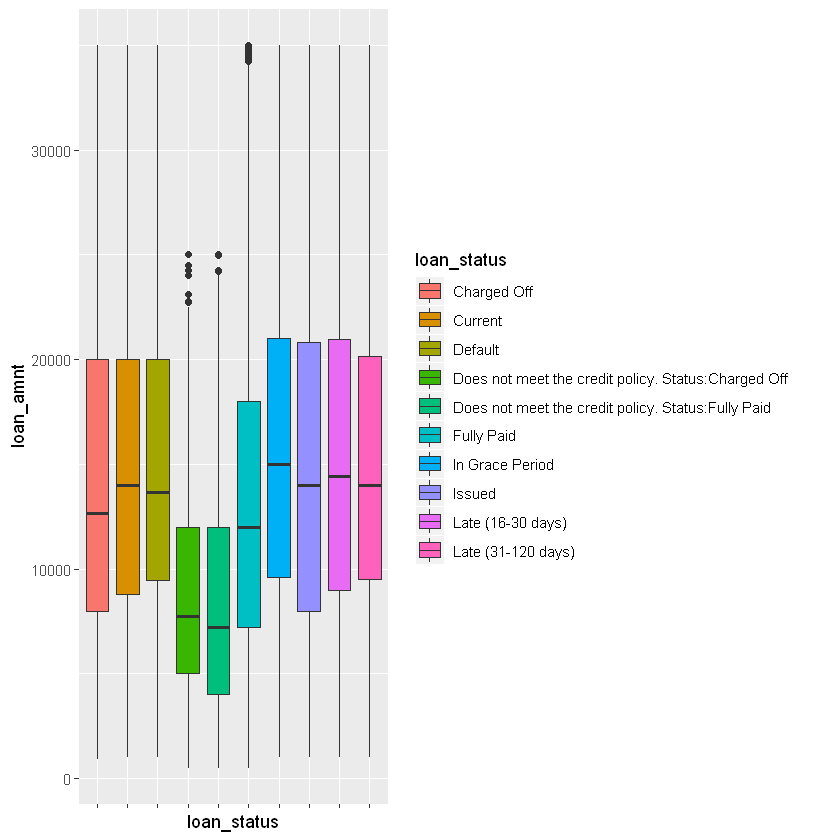

In [28]:
loan_status <- ggplot(loans, aes(loan_status, loan_amnt))
loan_status + geom_boxplot(aes(fill = loan_status)) +
  theme(axis.text.x = element_blank()) +
  labs(list(
    title = "Loan amount by status",
    x = "Status",
    y = "Amount"))  

<p>It is not immediately obvious what the different values stand for, so we refer to Lending Club&rsquo;s documentation about &ldquo;<a href="https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-">What do the different Note statuses mean?</a>&rdquo;</p>
<ul>
<li>Fully Paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.</li>
<li>Current: Loan is up to date on all outstanding payments.</li>
<li>Does not meet the credit policy. Status:Fully Paid: No explanation but see &ldquo;fully paid&rdquo;.</li>
<li>Issued: New loan that has passed all Lending Club reviews, received full funding, and has been issued.</li>
<li>Charged Off: Loan for which there is no longer a reasonable expectation of further payments. Generally, Charge Off occurs no later than 30 days after the Default status is reached. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the&nbsp;<a href="https://help.lendingclub.com/hc/en-us/articles/216127747">difference between &ldquo;default&rdquo; and &ldquo;charge off&rdquo;</a>.</li>
<li>Does not meet the credit policy. Status:Charged Off: No explanation but see &ldquo;Charged Off&rdquo;</li>
<li>Late (31-120 days): Loan has not been current for 31 to 120 days.</li>
<li>In Grace Period: Loan is past due but within the 15-day grace period.</li>
<li>Late (16-30 days): Loan has not been current for 16 to 30 days.</li>
<li>Default: Loan has not been current for 121 days or more.</li>
</ul>
<p>Given above information, we will define a default as follows:</p>
<p><strong><span style="text-decoration: underline;">Defaulted</span> </strong>loans are in status:</p>
<ol>
<li>Charged Off</li>
<li>Does not meet the credit policy. Status:Charged Off</li>
</ol>
<p><strong><span style="text-decoration: underline;">Fully Paid</span></strong> loans are in status:</p>
<ol>
<li>Fully Paid</li>
<li>Does not meet the credit policy. Status:Fully Paid</li>
</ol>
<p>For the other possible statuses we don't have a definite outcome of the loan therefore for these stage we will omit them from our dataset.<br />**In later stages we will consider restore some of the statuses back.</p>

In [29]:
nrow(loans)
status<-c("Current", "Default","In Grace Period", "Issued", "Late (16-30 days)",
          "Late (16-30 days)", "Late (31-120 days)"  ) 


loans <-
loans %>% filter(!(loan_status %in% status))
nrow(loans)

[1] 886871

[1] 255720

In [30]:
Charged_Off <- 
  c( "Charged Off",
    "Does not meet the credit policy. Status:Charged Off")


In [31]:
loans <-
  loans %>%
  mutate(default = ifelse(!(loan_status %in% Charged_Off), FALSE, TRUE))


<p>Remove loan_status column because it has been used to define target variable</p>

In [32]:
loans <- loans %>% select(-one_of("loan_status"))

<h3>Columns which are indications of the outcome (confounders) - determined by Lending Club after the company evaluations of the credit risk. In our work, we want to estimate the credit risk by ourselves based on the data we have. </h3>
<ol>
<li>grade</li>
<li>sub_grade</li>
<li>int_rate</li>
</ol>


In [33]:
exclude <- c("grade","sub_grade","int_rate")
ncol(loans)
loans <- excludeColumns(loans,exclude)
ncol(loans)

[1] 65

[1] 62

Installment values are computed with the interest rate that was defined to the loan by Lending Club.
We will add a new feature called <u><b>loan_installment</b></u> that will defined by loanAmount divided by the term without interest rate calcualation.

In [34]:
loans <-
  loans %>% mutate(loan_installment = ifelse(term == 0,round(loan_amnt/36,2) , round(loan_amnt/60,2)))

loans <- loans %>% select(-one_of("installment"))

<h3>Excluding Columns (2)</h3>
<p>After definition of our outcome value and definition of our question we can remove all columns that are not present at the time of deciding whether to approve a loan or not and retain variables related to customer information:</p>
<ul>
<li>last_pymnt_d</li>
<li>next_pymnt_d</li>
<li>collection_recovery_fee</li>
<li>last_pymnt_amnt</li>
<li>out_prncp</li>
<li>out_prncp_inv</li>
<li>recoveries</li>
<li>total_pymnt</li>
<li>total_pymnt_inv</li>
<li>total_rec_int</li>
<li>total_rec_late_fee</li>
<li>total_rec_prncp</li>
</ul>

<p>By their definitions below they all relate to <strong>later </strong>or <strong>current</strong> stages of the loan therefore are not relevant to the <strong>initiate</strong> state of the loan</p>

In [35]:
exclude <- c("last_pymnt_d","next_pymnt_d","collection_recovery_fee","last_pymnt_amnt",
             "out_prncp","out_prncp_inv","recoveries","total_pymnt",
             "total_pymnt_inv","total_rec_int","total_rec_late_fee","total_rec_prncp"           
            )
meta_loan_stats[,1:2] %>% filter(LoanStatNew %in% exclude)

LoanStatNew,Description
collection_recovery_fee,post charge off collection fee
last_pymnt_amnt,Last total payment amount received
last_pymnt_d,Last month payment was received
next_pymnt_d,Next scheduled payment date
out_prncp,Remaining outstanding principal for total amount funded
out_prncp_inv,Remaining outstanding principal for portion of total amount funded by investors
recoveries,post charge off gross recovery
total_pymnt,Payments received to date for total amount funded
total_pymnt_inv,Payments received to date for portion of total amount funded by investors
total_rec_int,Interest received to date


In [37]:
ncol(loans)
loans <- excludeColumns(loans,exclude)
ncol(loans)

[1] 50

[1] 50

In [64]:
#Recreate Meta Loans
meta_loans <- funModeling::df_status(loans, print_results = FALSE)
meta_loans <-
  meta_loans %>%
  mutate(uniq_rat = unique / nrow(loans)) %>%
  mutate(unique = unique, uniq_rat = scales::percent(uniq_rat))

In [38]:
cv <- c('verification_status','loanDesc', 'purpose' ,'title','emp_length','zip_code', 'addr_state', 'home_ownership')
meta_loans %>%
  select(variable, p_zeros, p_na, unique,uniq_rat) %>% arrange(desc(p_na))  %>% filter_(~ variable %in% cv)

variable,p_zeros,p_na,unique,uniq_rat
loanDesc,0,85.80,124470,1.402665e-01
title,0,0.02,63145,7.115876e-02
verification_status,0,0.00,3,3.380731e-06
purpose,0,0.00,14,1.577675e-05
emp_length,0,0.00,12,1.352292e-05
zip_code,0,0.00,935,1.053661e-03
addr_state,0,0.00,51,5.747243e-05
home_ownership,0,0.00,6,6.761462e-06


<h3>Excluding Columns (3)</h3>
<ol>
<li>An attribute <span style="text-decoration: underline; color: #0000ff;">loanDesc </span>has over 30% unique values, it seems borrowers are free to describe their loan application. <br /><em><span style="text-decoration: underline;">Note:</span> </em>In a more sophisticated modeling , may be used to checking the strings for &ldquo;indicator words&rdquo; that may be associated with an honest or a dishonest candidate as we have the purpose of the loan.</li>
<li>An attribute <span style="text-decoration: underline; color: #0000ff;">title </span>has a lot of unique values, it seems borrowers are free to describe their title for the loan application. <br /><em><span style="text-decoration: underline;">Note:</span> </em>In a more sophisticated modeling , may be used to checking the strings for &ldquo;indicator words&rdquo; that may be associated with an honest or a dishonest candidate as we have the purpose of the loan.</li>
</ol>

In [39]:
exclude <- c("loanDesc","title")
ncol(loans)
loans <- excludeColumns(loans,exclude)
ncol(loans)

[1] 50

[1] 48

<b>Check the demographics columns

In [71]:
head(loans %>% select(zip_code,addr_state))

zip_code,addr_state
860xx,AZ
309xx,GA
606xx,IL
917xx,CA
852xx,AZ
900xx,CA


<p>We can see that the zip codes in our dataset are only the first 3 digits and then XX.</p>
<p>By Wikipedia&nbsp;<a href="https://en.wikipedia.org/wiki/List_of_ZIP_code_prefixes">ZipCodePrefixes</a>&nbsp;-<br />three-digit ZIP code prefix shows where that ZIP code prefix is located, and the name of the&nbsp;<a title="United States Postal Service" href="https://en.wikipedia.org/wiki/United_States_Postal_Service">United States Postal Service</a>&nbsp;(USPS)&nbsp;<a class="mw-redirect" title="Sectional Center Facility" href="https://en.wikipedia.org/wiki/Sectional_Center_Facility">Sectional Center Facility</a>&nbsp;(SCF) that serves that ZIP code prefix.</p>
<p>We can't detect the exact city from it so we will remove this column and stay only with the state definition.</p>
<p>The states are also abbreviated to their 2 letters representation.</p>
<p>We will transform this column to the full state name using openintro package with a function
<pre><a id="sym-abbr2state" class="mini-popup mini-highlight visible" href="https://rdrr.io/cran/openintro/man/abbr2state.html" data-mini-url="/cran/openintro/man/abbr2state.minihtml">abbr2state</a></pre></p>

In [72]:
copy1 <- loans

In [40]:
loans <- loans %>% select(-one_of("zip_code"))
loans <- loans %>%select(everything())%>%mutate(full_state= abbr2state(loans$addr_state)) 
head(loans %>% select(addr_state,full_state))
loans <- loans %>% select(-one_of("addr_state"))

addr_state,full_state
AZ,Arizona
GA,Georgia
IL,Illinois
CA,California
AZ,Arizona
CA,California


<b>Data Enrichment

1.We have variables that show the number of credits lines in the borrower's credit file

In [42]:
meta_loan_stats[,1:2] %>% filter(LoanStatNew %in% c('open_acc','total_acc'))

LoanStatNew,Description
open_acc,The number of open credit lines in the borrower's credit file.
total_acc,The total number of credit lines currently in the borrower's credit file


We will create new variable that have the ratio between the open and the total counts

In [45]:
loans <-loans %>% mutate(acc_ratio = open_acc/total_acc)

2.We have two date variables that show the date of the first credit line and the last pull that was made by Lending Club

In [46]:
meta_loan_stats[,1:2] %>% filter(LoanStatNew %in% c('earliest_cr_line','last_credit_pull_d'))

LoanStatNew,Description
earliest_cr_line,The month the borrower's earliest reported credit line was opened
last_credit_pull_d,The most recent month LC pulled credit for this loan


We will create new variable that have the length or age of credit history in number of years <br>
Defined as  year(last_credit_pull_d) - year(earliest_cr_line)

In [67]:
loans <- loans %>% mutate(credit_history.d = as.integer(format(as.Date(earliest_cr_line, format="%d/%m/%Y"),"%Y"))) %>% 
mutate(pull.d = as.integer(format(as.Date(last_credit_pull_d, format="%d/%m/%Y"),"%Y")))  %>% 
mutate(credit_hist = pull.d-credit_history.d)%>% 
select(-one_of("credit_history.d","pull.d"))


Now we can remove the dates variables also.

In [68]:
exclude <- c("earliest_cr_line","last_credit_pull_d")
ncol(loans)
loans <- excludeColumns(loans,exclude)
ncol(loans)

[1] 49

[1] 47

3.We will create a variable that will show the poverty rate in the specific state in the time of the loan issue date

In [69]:
poverty_rate_ds <- readSQL("select * from povertyRateByStates")

In [77]:
loans_temp <- loans %>% mutate(full_state_l=tolower(full_state))%>% mutate(issue_year=format(as.Date(issue_d, format="%d/%m/%Y"),"%Y"))

poverty_rateByYears<- poverty_rate_ds%>%mutate(state_name=tolower(state_name))%>% select(year,poverty_rate_p,state_name)
loans_merged <- merge(loans_temp, poverty_rateByYears, by.x = c("issue_year","full_state_l"), by.y = c("year","state_name"))
exclude <- c("issue_year","full_state_l")
loans_merged <- excludeColumns(loans_merged,exclude)

In [78]:
loans <- loans_merged

In [79]:
##SQLLite Converts the date to numeric so imlilictly apply as.character on date columns
loans$issue_d <- as.character(loans$issue_d)


In [81]:
##saving the file and table
#write.csv(loans, file = "loans_db.csv",row.names=FALSE)
writeSQL(loans, "loans_dataset")